<a href="https://colab.research.google.com/github/dancher00/dls/blob/main/Attention_and_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/13YIbphbWc62sfa-bCh8MLQWKizaXbQK9/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

## Импорты и загрузка данных

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from typing import Union, List, Dict
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import copy
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print({device})

{device(type='cuda')}


In [4]:
df = pd.read_csv('data_problems_translated.xlsx - Sheet1.csv')
print(f"Размер датасета: {len(df)}")
print(f"Классы: {df['topic'].unique()}")

Размер датасета: 5273
Классы: ['number_theory' 'polynoms' 'combinatorics' 'graphs' 'geometry'
 'invariant' 'dirichlet']


In [7]:
le = LabelEncoder()
df['topic_encoded'] = le.fit_transform(df['topic'])

X_train, X_val, y_train, y_val = train_test_split(
    df['problem_text'].values,
    df['topic_encoded'].values,
    test_size=0.2,
    random_state=42,
    stratify=df['topic_encoded']
)

num_classes = len(le.classes_)

**Hint:** не перезаписывайте модели, которые вы получите на каждом из этапов этого дз. Они ещё понадобятся.

### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [8]:
class TransformerClassificationModel(nn.Module):

    def __init__(self, base_transformer_model: Union[str, nn.Module], num_classes: int = None):
        super(TransformerClassificationModel, self).__init__()

        if isinstance(base_transformer_model, str):
            self.backbone = AutoModel.from_pretrained(base_transformer_model)
            self.tokenizer = AutoTokenizer.from_pretrained(base_transformer_model)
        else:
            self.backbone = base_transformer_model
            # Если передана модель, нужно будет передать токенайзер отдельно
            self.tokenizer = None

        hidden_size = self.backbone.config.hidden_size

        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(hidden_size, num_classes if num_classes else 1)

    def forward(self, input_ids, attention_mask=None, return_attention=False):
        outputs = self.backbone(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_attentions=return_attention
        )

        pooled_output = outputs.last_hidden_state[:, 0, :]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        result = {'logits': logits}

        if return_attention:
            result['attention'] = outputs.attentions

        return result

### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [9]:
def freeze_backbone_function(model: TransformerClassificationModel):
    # Замораживаем все параметры backbone
    for param in model.backbone.parameters():
        param.requires_grad = False

    # Размораживаем параметры классификатора
    for param in model.classifier.parameters():
        param.requires_grad = True

    return model

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

In [10]:
import copy

class MathProblemDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def train_transformer(transformer_model, freeze_backbone=True,
                     train_texts=None, train_labels=None,
                     val_texts=None, val_labels=None,
                     epochs=3, batch_size=16, learning_rate=2e-5):
    model = copy.deepcopy(transformer_model)
    model = model.to(device)

    if freeze_backbone:
        model = freeze_backbone_function(model)
        print("Backbone заморожен")
    else:
        for param in model.parameters():
            param.requires_grad = True
        print("Все параметры разморожены")

    if train_texts is None:
        train_texts = X_train
        train_labels = y_train
        val_texts = X_val
        val_labels = y_val

    train_dataset = MathProblemDataset(train_texts, train_labels, model.tokenizer)
    val_dataset = MathProblemDataset(val_texts, val_labels, model.tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=learning_rate
    )
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0.0
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs['logits']

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        model.eval()
        val_predictions = []
        val_true = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs['logits']

                predictions = torch.argmax(logits, dim=1)
                val_predictions.extend(predictions.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        val_acc = accuracy_score(val_true, val_predictions)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Val Accuracy = {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc

    print(f"Лучшая точность на валидации: {best_val_acc:.4f}")

    return model

### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

In [11]:
rubert_tiny_transformer_model = TransformerClassificationModel(
    base_transformer_model='cointegrated/rubert-tiny2',
    num_classes=num_classes
)
print("rubert-tiny2 создана")

# Дообучение с замороженным backbone
rubert_tiny_finetuned_with_freezed_backbone = train_transformer(
    rubert_tiny_transformer_model,
    freeze_backbone=True,
    epochs=3,
    batch_size=16,
    learning_rate=2e-5
)

# Создаем новую модель для полного дообучения
rubert_tiny_transformer_model_full = TransformerClassificationModel(
    base_transformer_model='cointegrated/rubert-tiny2',
    num_classes=num_classes
)

# Дообучение без заморозки backbone
rubert_tiny_full_finetuned = train_transformer(
    rubert_tiny_transformer_model_full,
    freeze_backbone=False,
    epochs=3,
    batch_size=16,
    learning_rate=2e-5
)

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:01, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

rubert-tiny2 создана
Backbone заморожен


Epoch 1/3: 100%|██████████| 264/264 [00:12<00:00, 20.74it/s]


Epoch 1: Loss = 1.8711, Val Accuracy = 0.4009


Epoch 2/3: 100%|██████████| 264/264 [00:14<00:00, 18.27it/s]


Epoch 2: Loss = 1.7169, Val Accuracy = 0.4559


Epoch 3/3: 100%|██████████| 264/264 [00:15<00:00, 16.64it/s]


Epoch 3: Loss = 1.6345, Val Accuracy = 0.4559
Лучшая точность на валидации: 0.4559
Все параметры разморожены


Epoch 1/3: 100%|██████████| 264/264 [00:33<00:00,  7.78it/s]


Epoch 1: Loss = 1.3783, Val Accuracy = 0.5839


Epoch 2/3: 100%|██████████| 264/264 [00:30<00:00,  8.72it/s]


Epoch 2: Loss = 1.0896, Val Accuracy = 0.6095


Epoch 3/3: 100%|██████████| 264/264 [00:33<00:00,  7.95it/s]


Epoch 3: Loss = 0.9691, Val Accuracy = 0.6265
Лучшая точность на валидации: 0.6265


### Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

In [12]:
mathbert_model = TransformerClassificationModel(
    base_transformer_model='tbs17/MathBERT',
    num_classes=num_classes
)

# Дообучение с замороженным backbone
mathbert_finetuned_with_freezed_backbone = train_transformer(
    mathbert_model,
    freeze_backbone=True,
    epochs=3,
    batch_size=16,
    learning_rate=2e-5
)

# Создаем новую модель для полного дообучения
mathbert_model_full = TransformerClassificationModel(
    base_transformer_model='tbs17/MathBERT',
    num_classes=num_classes
)

# Дообучение без заморозки backbone
mathbert_full_finetuned = train_transformer(
    mathbert_model_full,
    freeze_backbone=False,
    epochs=3,
    batch_size=16,
    learning_rate=2e-5
)

config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/441M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Backbone заморожен



Epoch 1/3: 100%|██████████| 264/264 [02:07<00:00,  2.07it/s]


Epoch 1: Loss = 1.7944, Val Accuracy = 0.4294


Epoch 2/3: 100%|██████████| 264/264 [02:15<00:00,  1.95it/s]


Epoch 2: Loss = 1.5821, Val Accuracy = 0.4389


Epoch 3/3: 100%|██████████| 264/264 [02:10<00:00,  2.02it/s]


Epoch 3: Loss = 1.5331, Val Accuracy = 0.4436
Лучшая точность на валидации: 0.4436
Все параметры разморожены


Epoch 1/3: 100%|██████████| 264/264 [06:20<00:00,  1.44s/it]


Epoch 1: Loss = 1.1712, Val Accuracy = 0.6218


Epoch 2/3: 100%|██████████| 264/264 [06:21<00:00,  1.45s/it]


Epoch 2: Loss = 0.8715, Val Accuracy = 0.5915


Epoch 3/3: 100%|██████████| 264/264 [06:21<00:00,  1.44s/it]


Epoch 3: Loss = 0.6854, Val Accuracy = 0.5507
Лучшая точность на валидации: 0.6218


MathBert специально обучен на математических текстах, поэтому ожидается, что он покажет лучшие результаты по сравнению с rubert-tiny2

Полное дообучение (без заморозки) обычно дает лучшие результаты,сно требует больше времени и ресурсов

### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

In [19]:
def draw_first_layer_attention_maps(attention_head_ids: List, text: str, model: TransformerClassificationModel):
    model.eval()
    model = model.to(device)

    tokens = model.tokenizer.tokenize(text)
    encoding = model.tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=512,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, return_attention=True)

    first_layer_attention = outputs['attention'][0]
    first_layer_attention = first_layer_attention[0]

    token_ids = input_ids[0].cpu().numpy()
    token_strings = [model.tokenizer.decode([tid]) for tid in token_ids]

    # Ограничиваем длину для визуализации
    max_len = min(50, len(token_strings))
    token_strings = token_strings[:max_len]

    num_heads_to_show = len(attention_head_ids)
    fig, axes = plt.subplots(1, num_heads_to_show, figsize=(10 *num_heads_to_show, 10))

    if num_heads_to_show == 1:
        axes = [axes]

    for idx, head_id in enumerate(attention_head_ids):
        if head_id >= first_layer_attention.shape[0]:
            print(f"Голова {head_id} не существует. Всего голов: {first_layer_attention.shape[0]}")
            continue

        # Берем attention для конкретной головы
        attention_weights = first_layer_attention[head_id, :max_len, :max_len].cpu().numpy()

        sns.heatmap(
            attention_weights,
            xticklabels=token_strings,
            yticklabels=token_strings,
            cmap='Blues',
            ax=axes[idx],
            cbar=True
        )
        axes[idx].set_title(f'Attention Head {head_id}')
        axes[idx].set_xlabel('Key')
        axes[idx].set_ylabel('Query')
        plt.setp(axes[idx].get_xticklabels(), rotation=45, ha='right', fontsize=8)
        plt.setp(axes[idx].get_yticklabels(), rotation=0, fontsize=8)

    plt.tight_layout()
    plt.show()

    return first_layer_attention

### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)


Текст 1: Inside the ABC triangle, the K point is taken, lying on the BAC angle biscrate. The direct CK crosse...


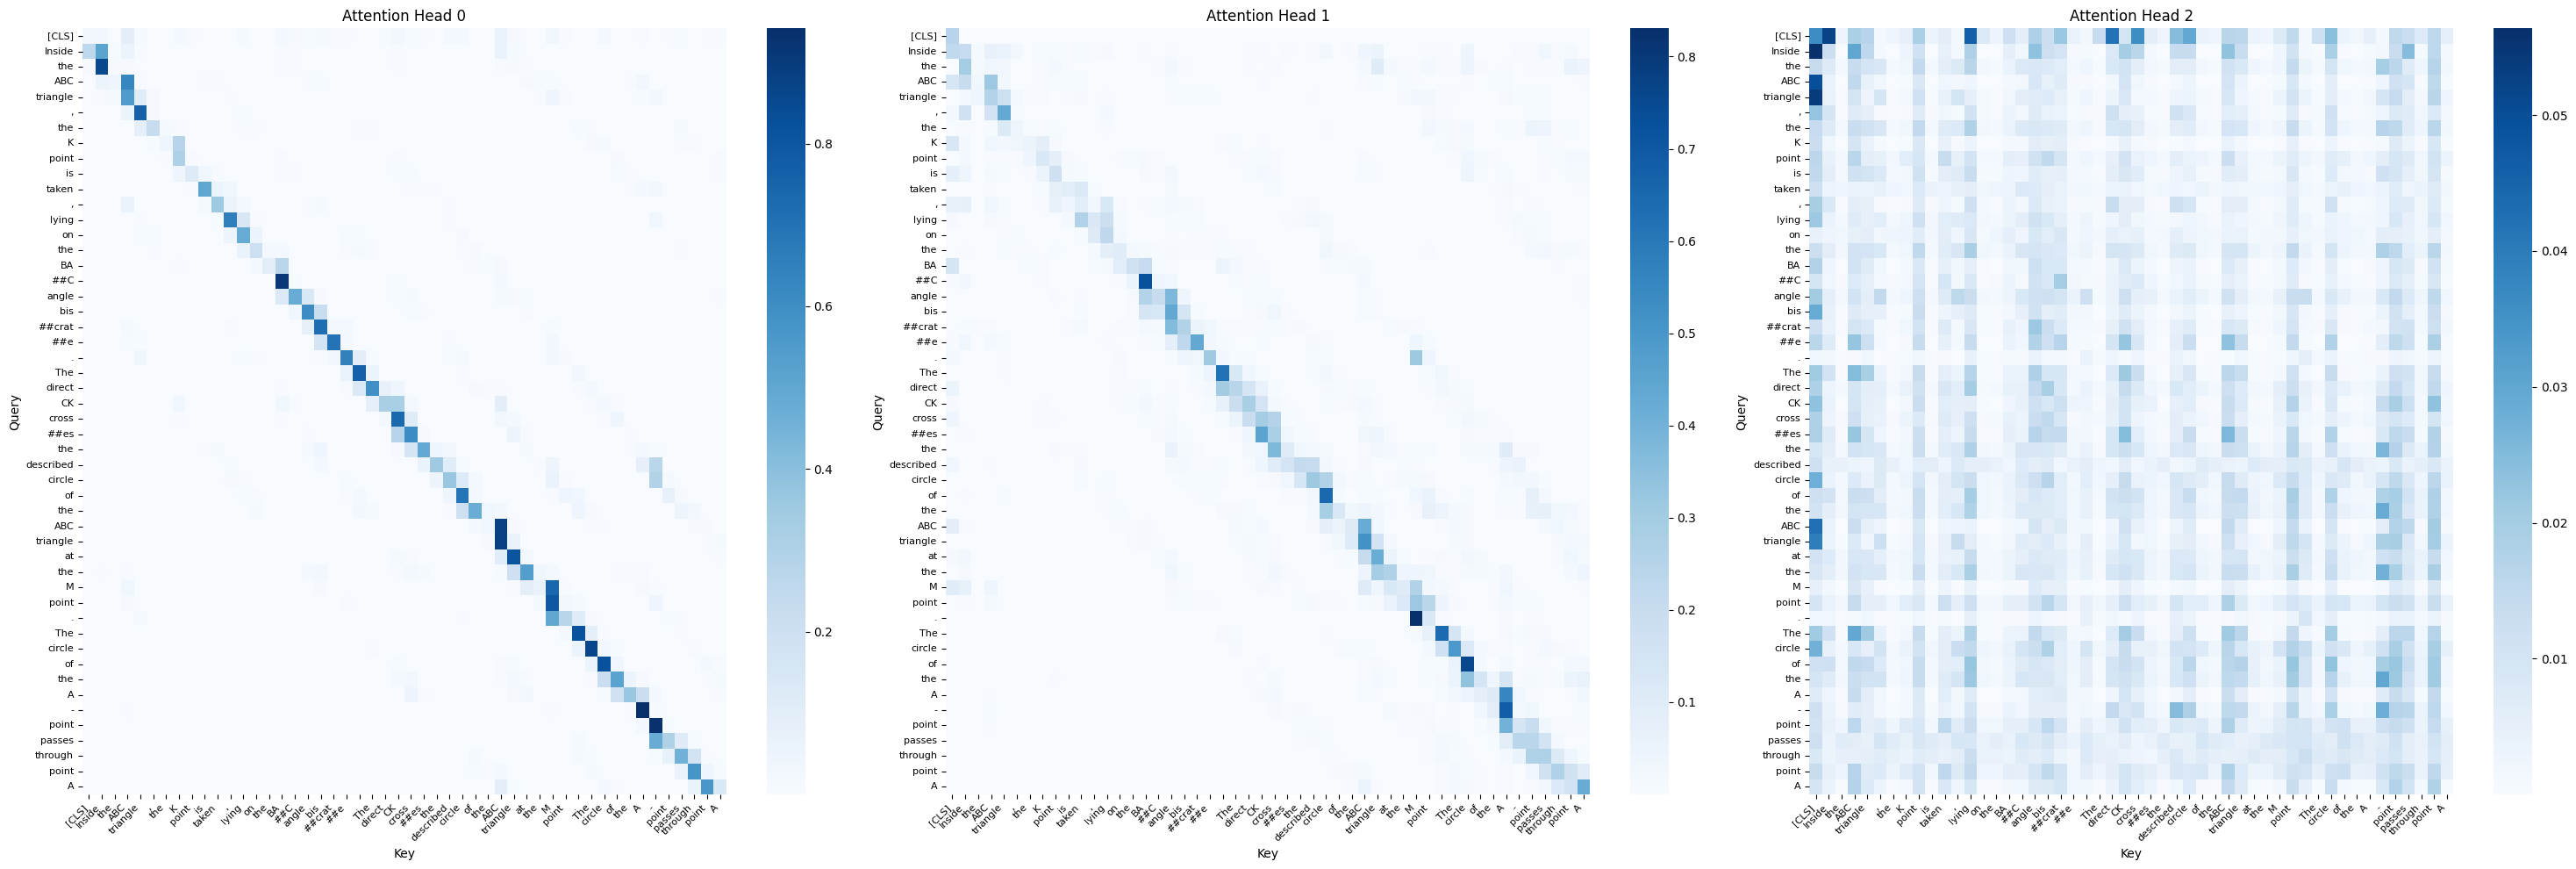


Текст 2: To find such 50 natural numbers that neither of them is divided into another, and the work of each o...


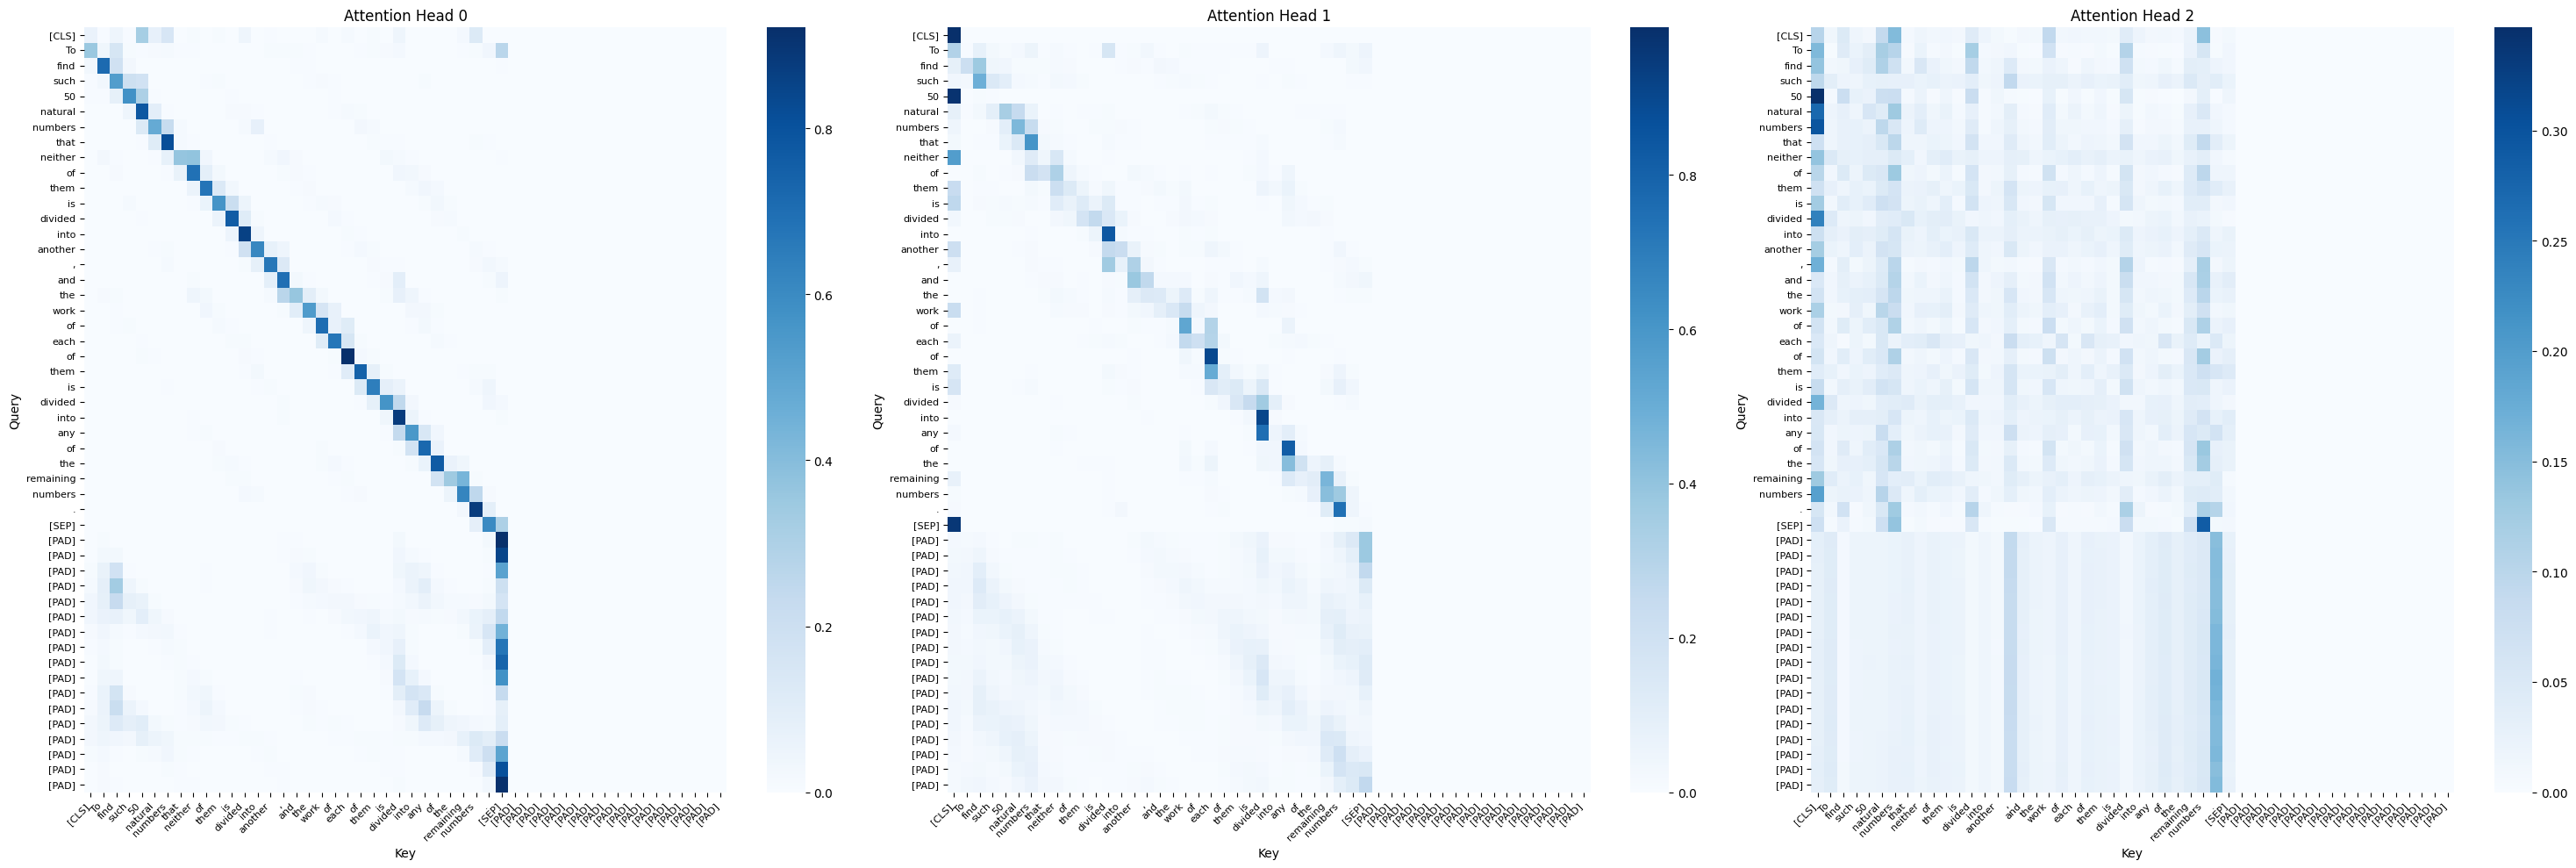


Текст 1: Inside the ABC triangle, the K point is taken, lying on the BAC angle biscrate. The direct CK crosse...


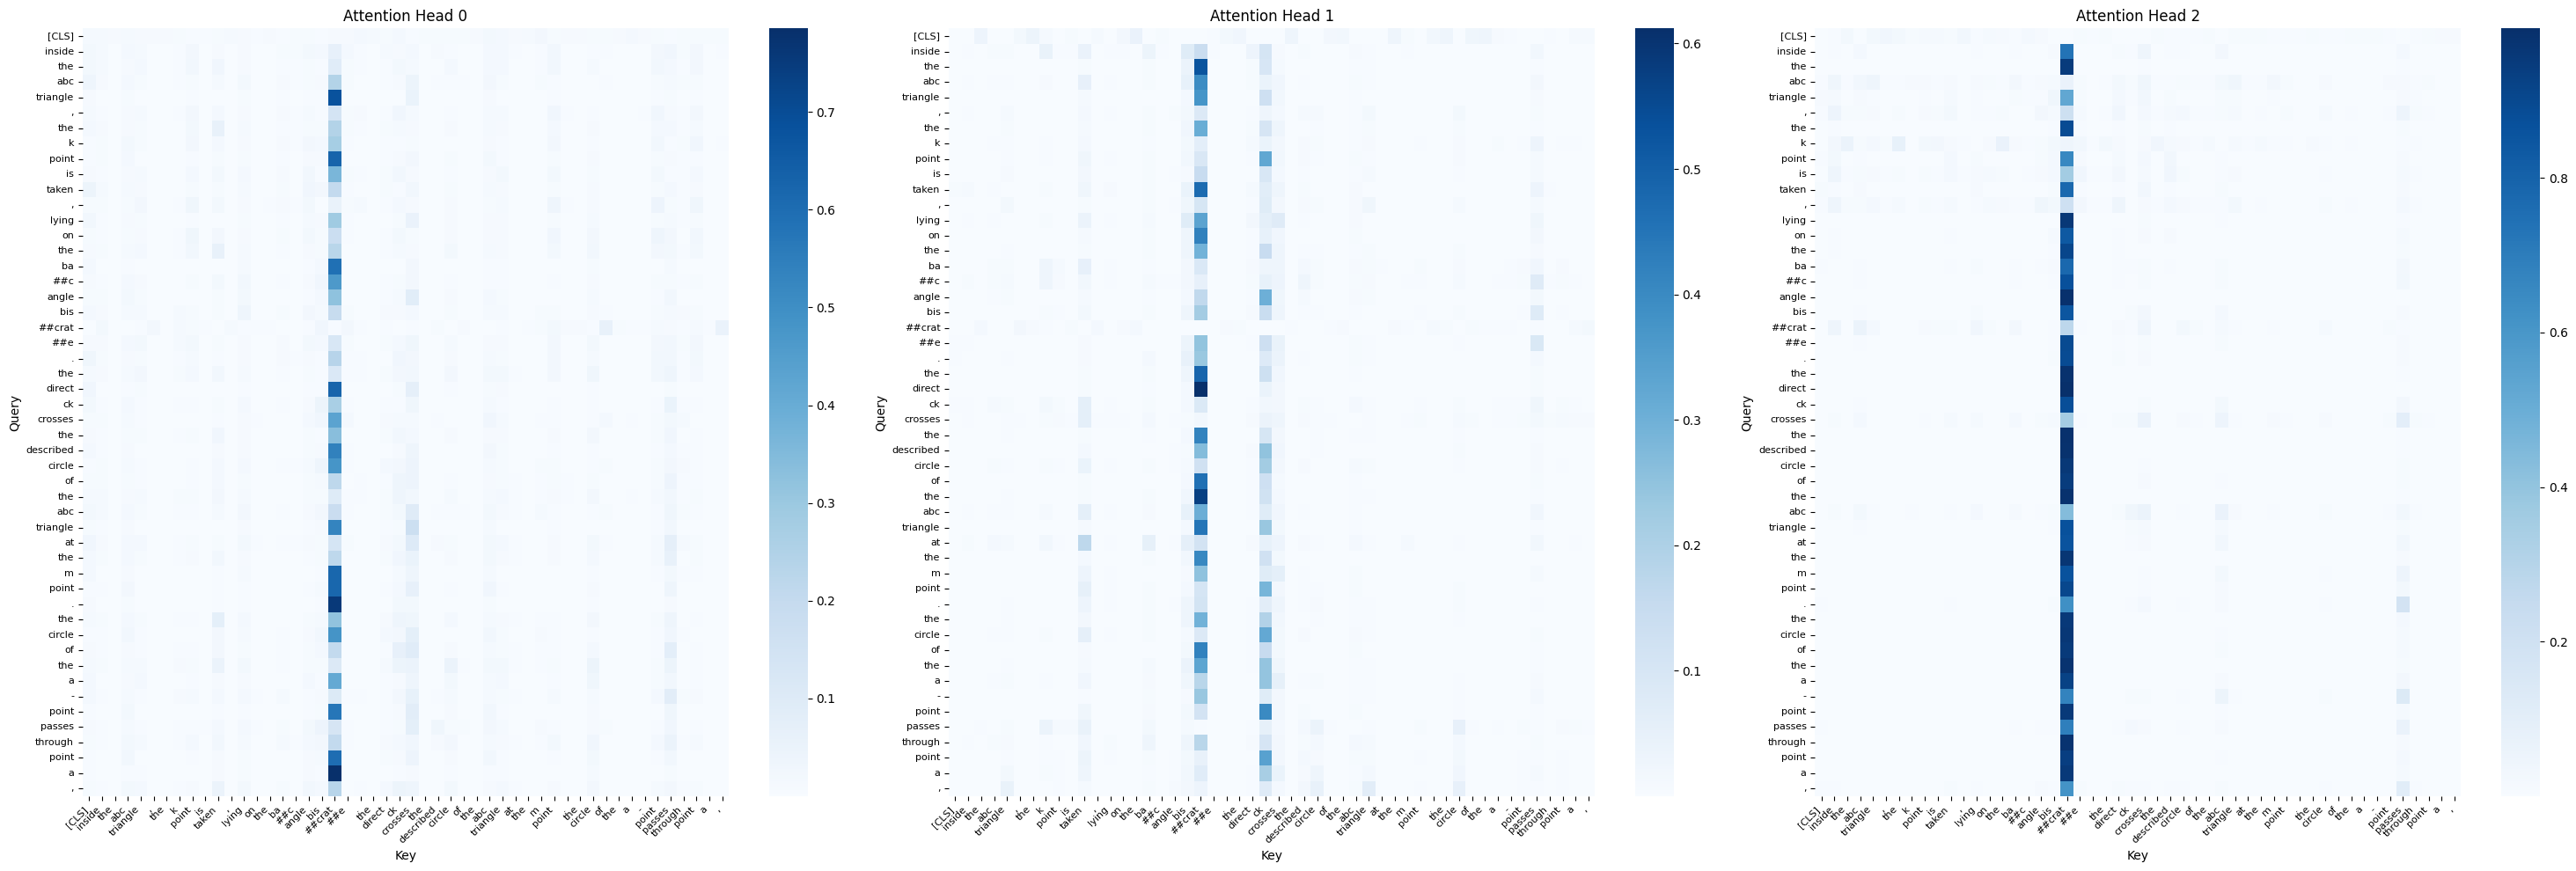


Текст 2: To find such 50 natural numbers that neither of them is divided into another, and the work of each o...


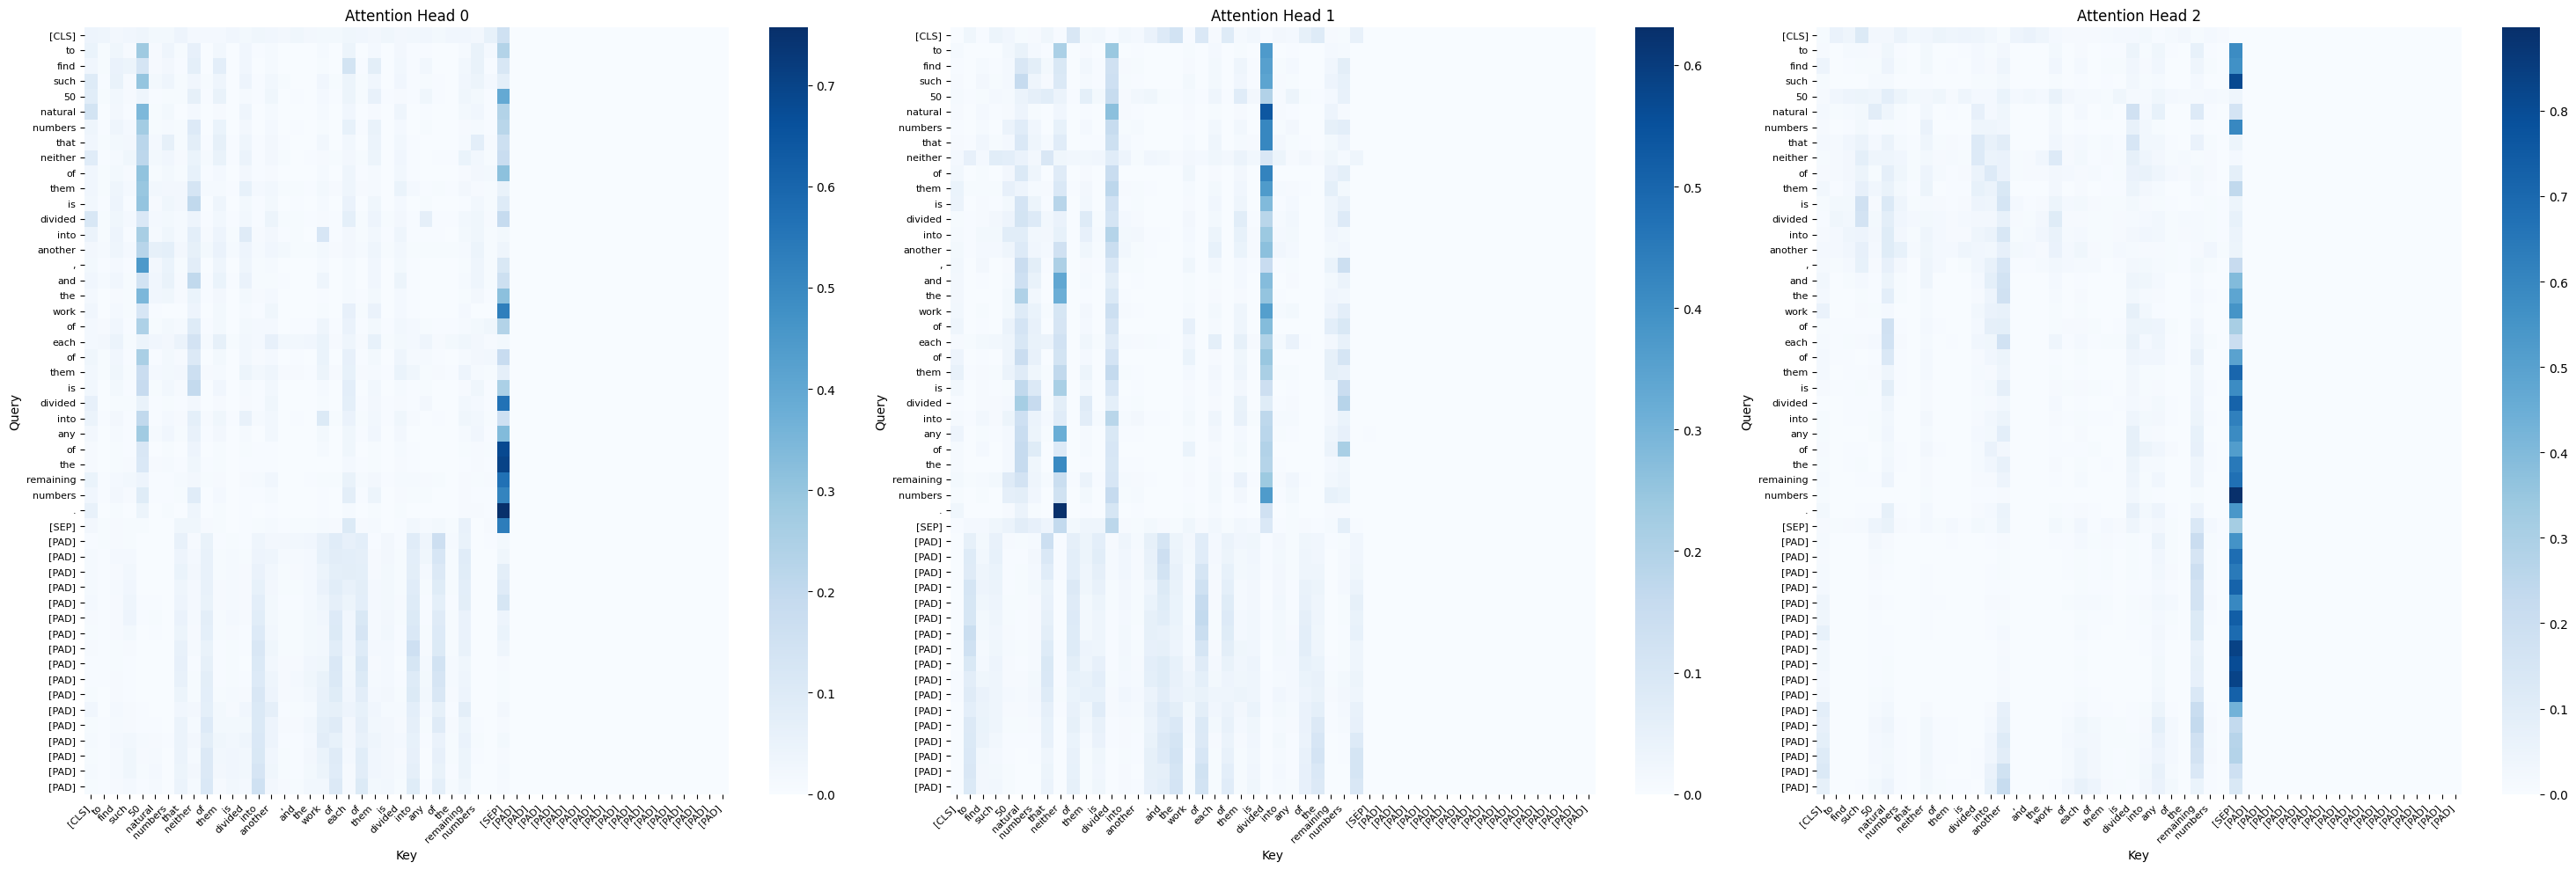

In [20]:
sample_texts = [
    X_train[0],
    X_train[100],
    X_train[200]
]


# 1. rubert-tiny2 (до обучения)
rubert_tiny_original = TransformerClassificationModel(
    base_transformer_model='cointegrated/rubert-tiny2',
    num_classes=num_classes
)

for i, text in enumerate(sample_texts[:2]):
    print(f"\nТекст {i+1}: {text[:100]}...")
    num_heads = rubert_tiny_original.backbone.config.num_attention_heads
    head_ids = [0, min(1, num_heads-1), min(2, num_heads-1)][:min(3, num_heads)]
    draw_first_layer_attention_maps(head_ids, text, rubert_tiny_original)

# 2. MathBert (до обучения)
mathbert_original = TransformerClassificationModel(
    base_transformer_model='tbs17/MathBERT',
    num_classes=num_classes
)

for i, text in enumerate(sample_texts[:2]):
    print(f"\nТекст {i+1}: {text[:100]}...")
    num_heads = mathbert_original.backbone.config.num_attention_heads
    head_ids = [0, min(1, num_heads-1), min(2, num_heads-1)][:min(3, num_heads)]
    draw_first_layer_attention_maps(head_ids, text, mathbert_original)

Голова 0: сильная диагональ — самовнимание, захватывает идентичность токенов.

Голова 1: диагональ + офф-диагональные связи - синтаксические и семантические связи (существительное - модификатор, например "triangle" - "ABC", "divided" - "into").

Голова 2: рассеянный паттерн — распределённое внимание, часто фокус на [SEP]/[PAD], захватывает глобальный контекст последовательности.

Разные головы специализируются: самовнимание, локальные синтаксические связи и глобальный контекст. Модель выделяет математические термины и их связи (например, геометрические объекты с их обозначениями).

### Задание 8 (1 балл)

Сделайте то же самое для дообученных моделей. Изменились ли карты внимания и связи, которые они улавливают? Почему?



Текст 1: Inside the ABC triangle, the K point is taken, lying on the BAC angle biscrate. The direct CK crosse...


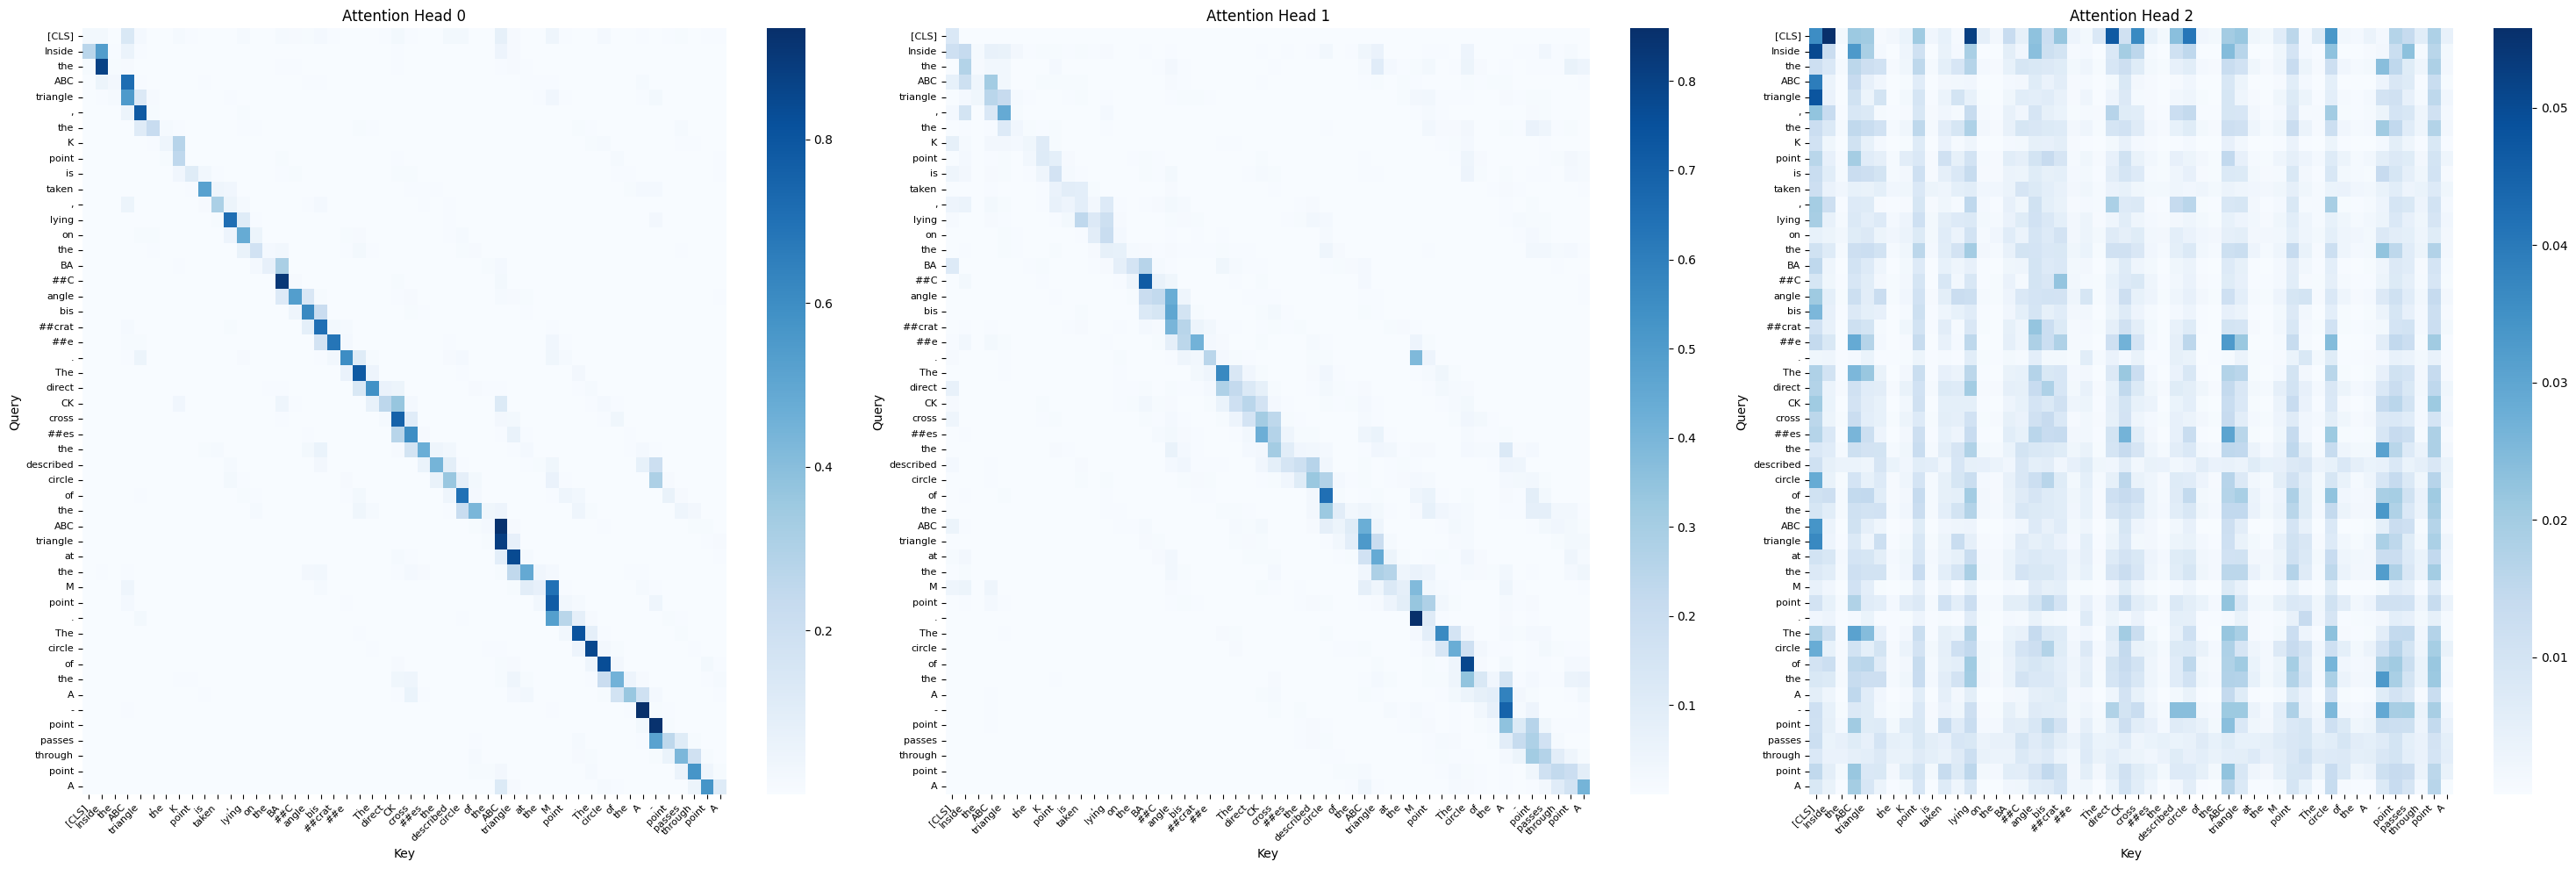


Текст 2: To find such 50 natural numbers that neither of them is divided into another, and the work of each o...


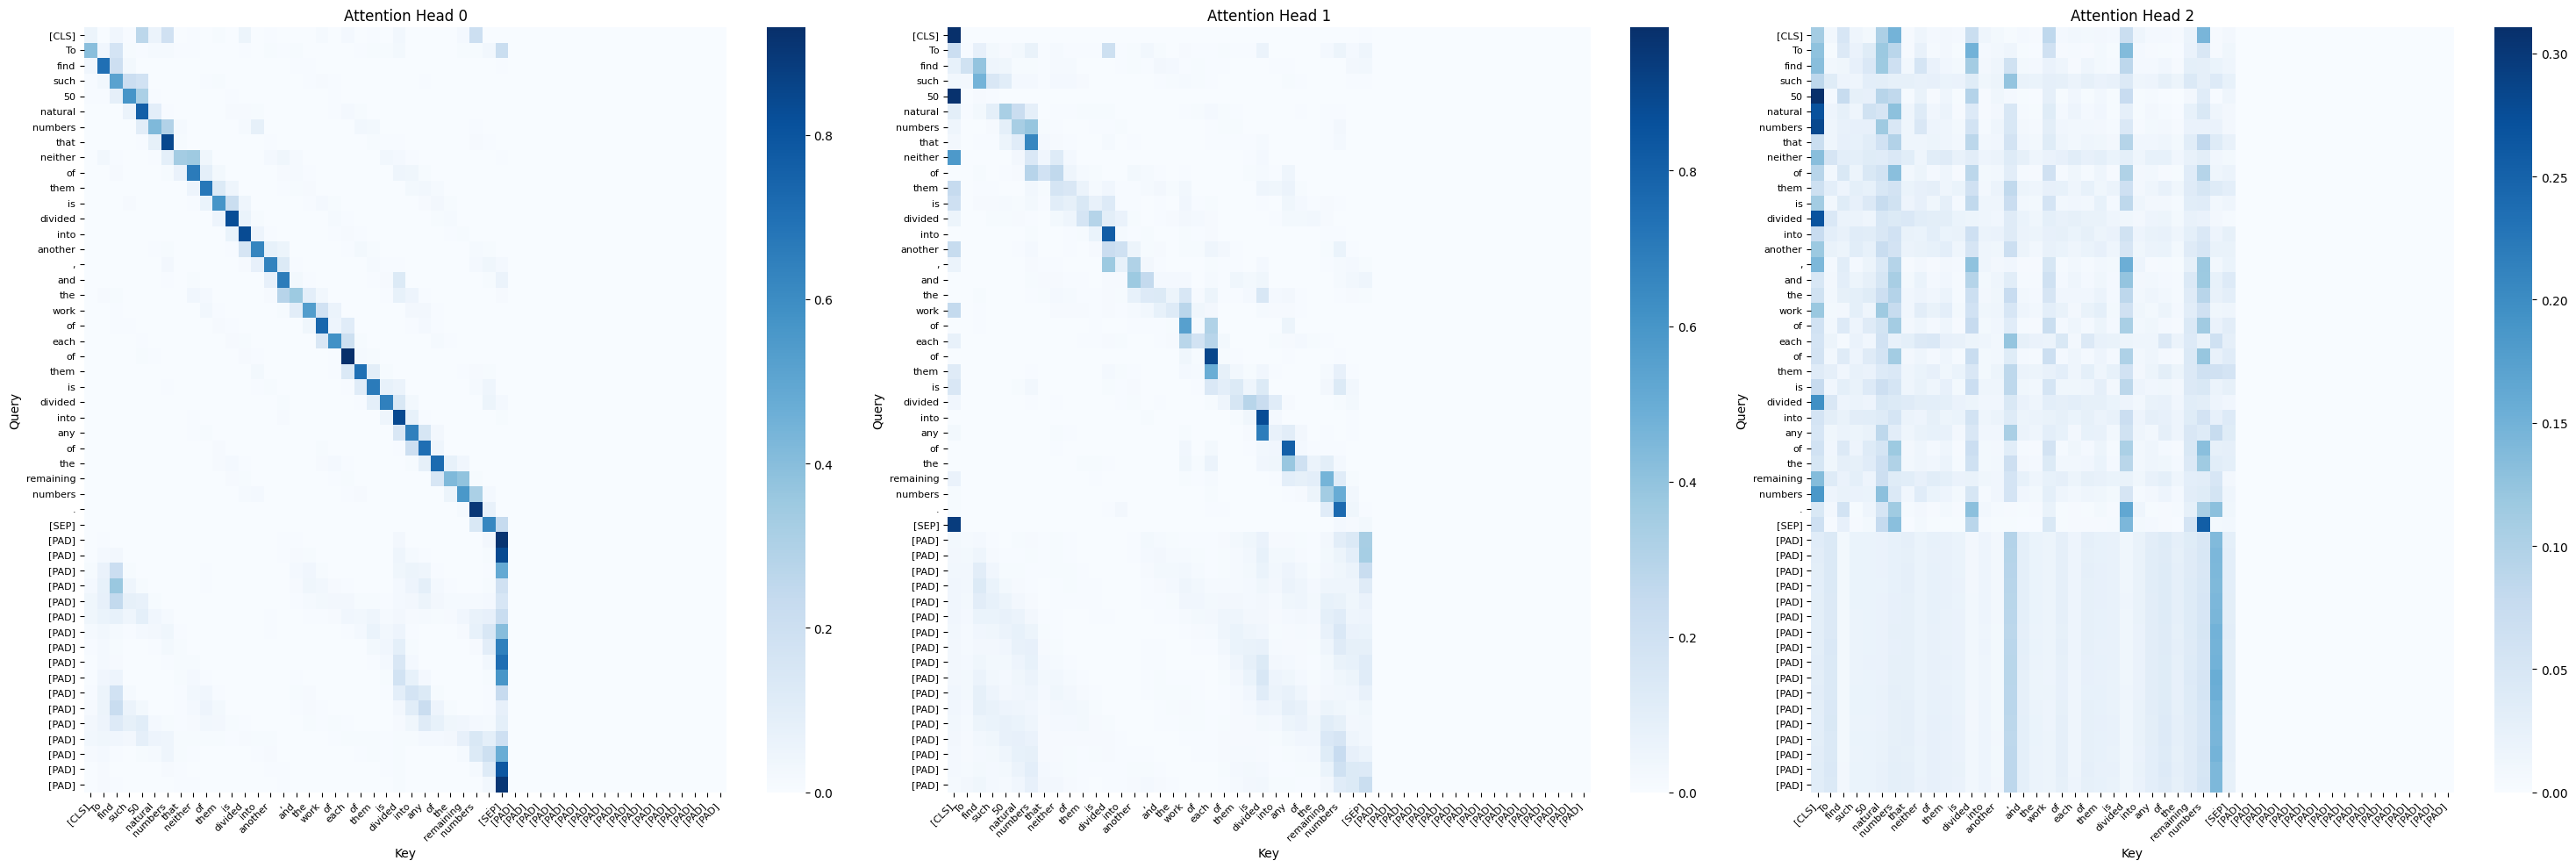


Текст 1: Inside the ABC triangle, the K point is taken, lying on the BAC angle biscrate. The direct CK crosse...


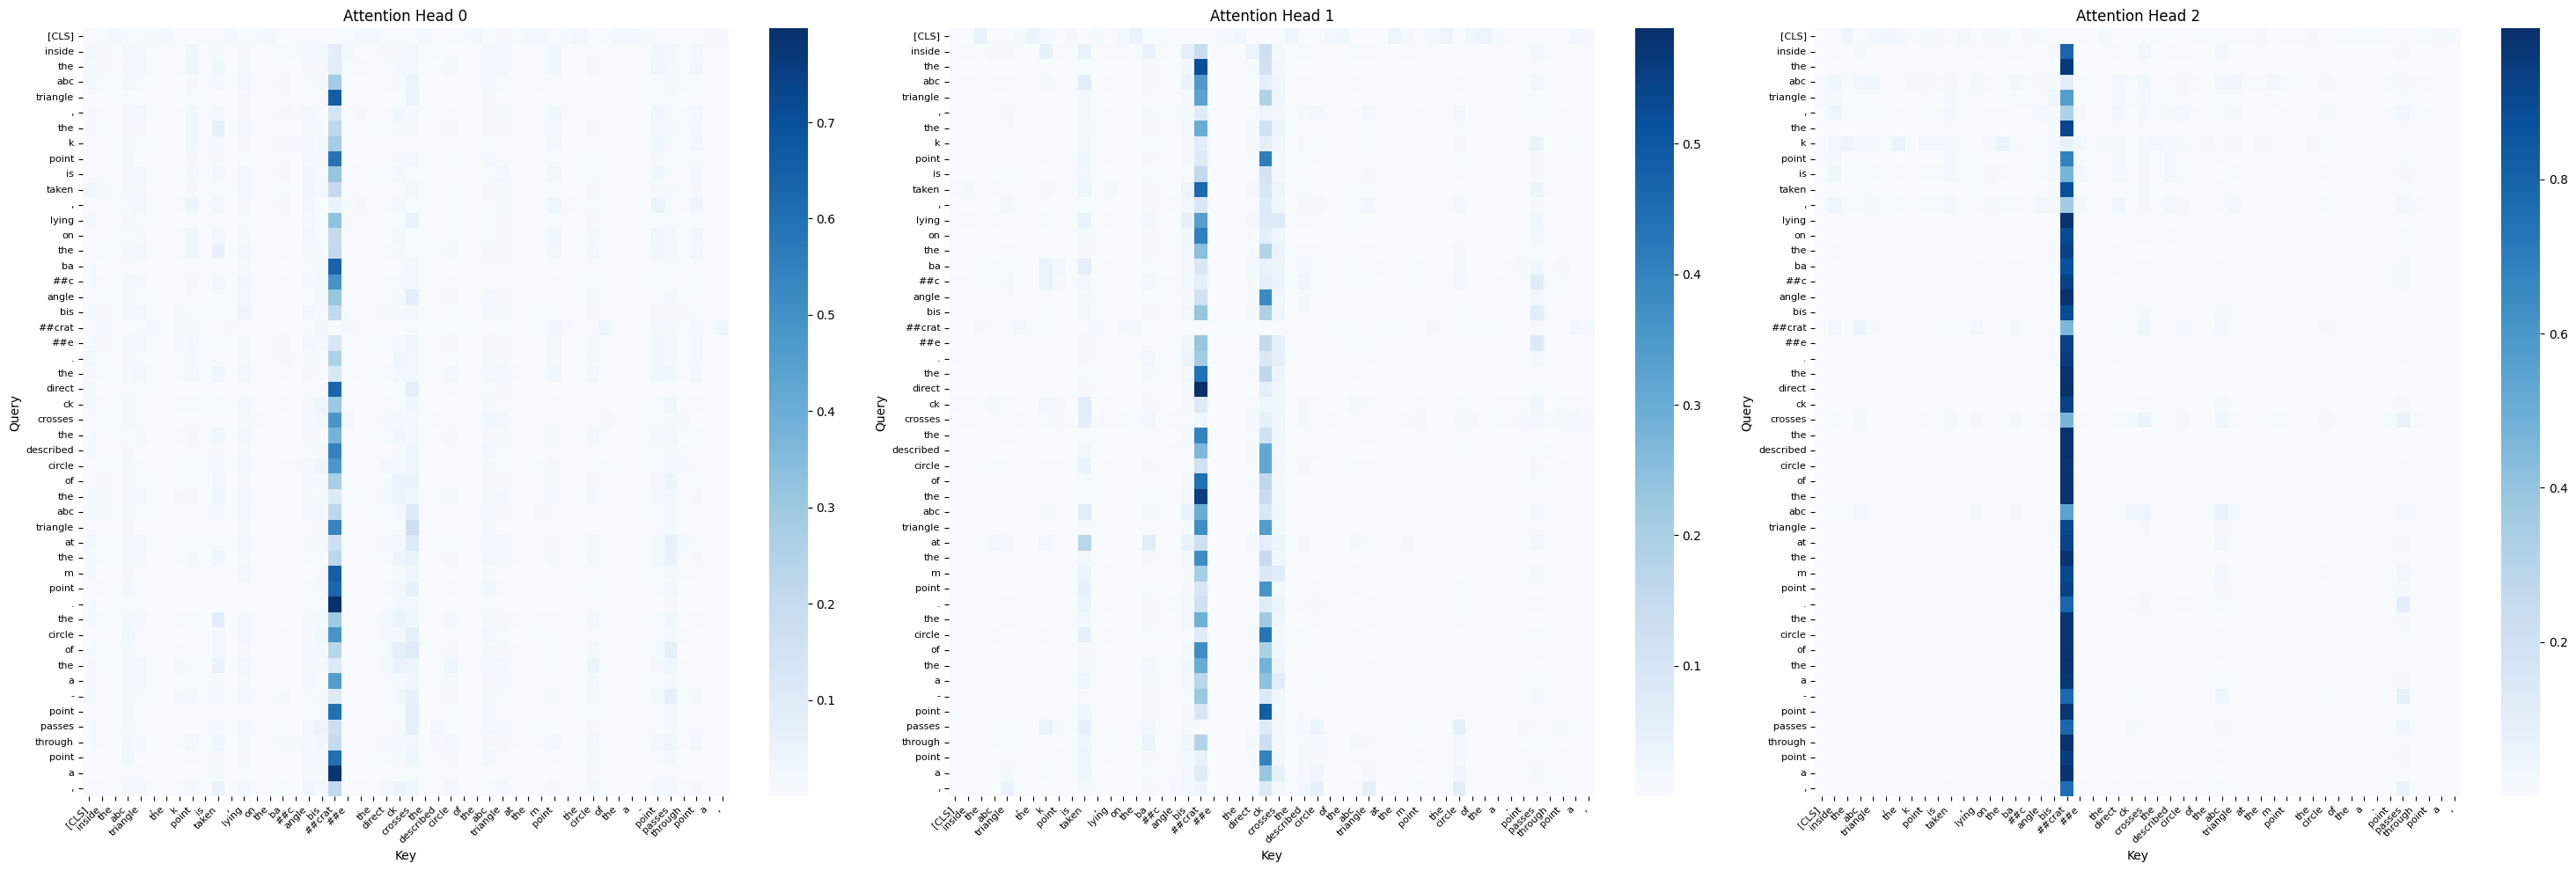


Текст 2: To find such 50 natural numbers that neither of them is divided into another, and the work of each o...


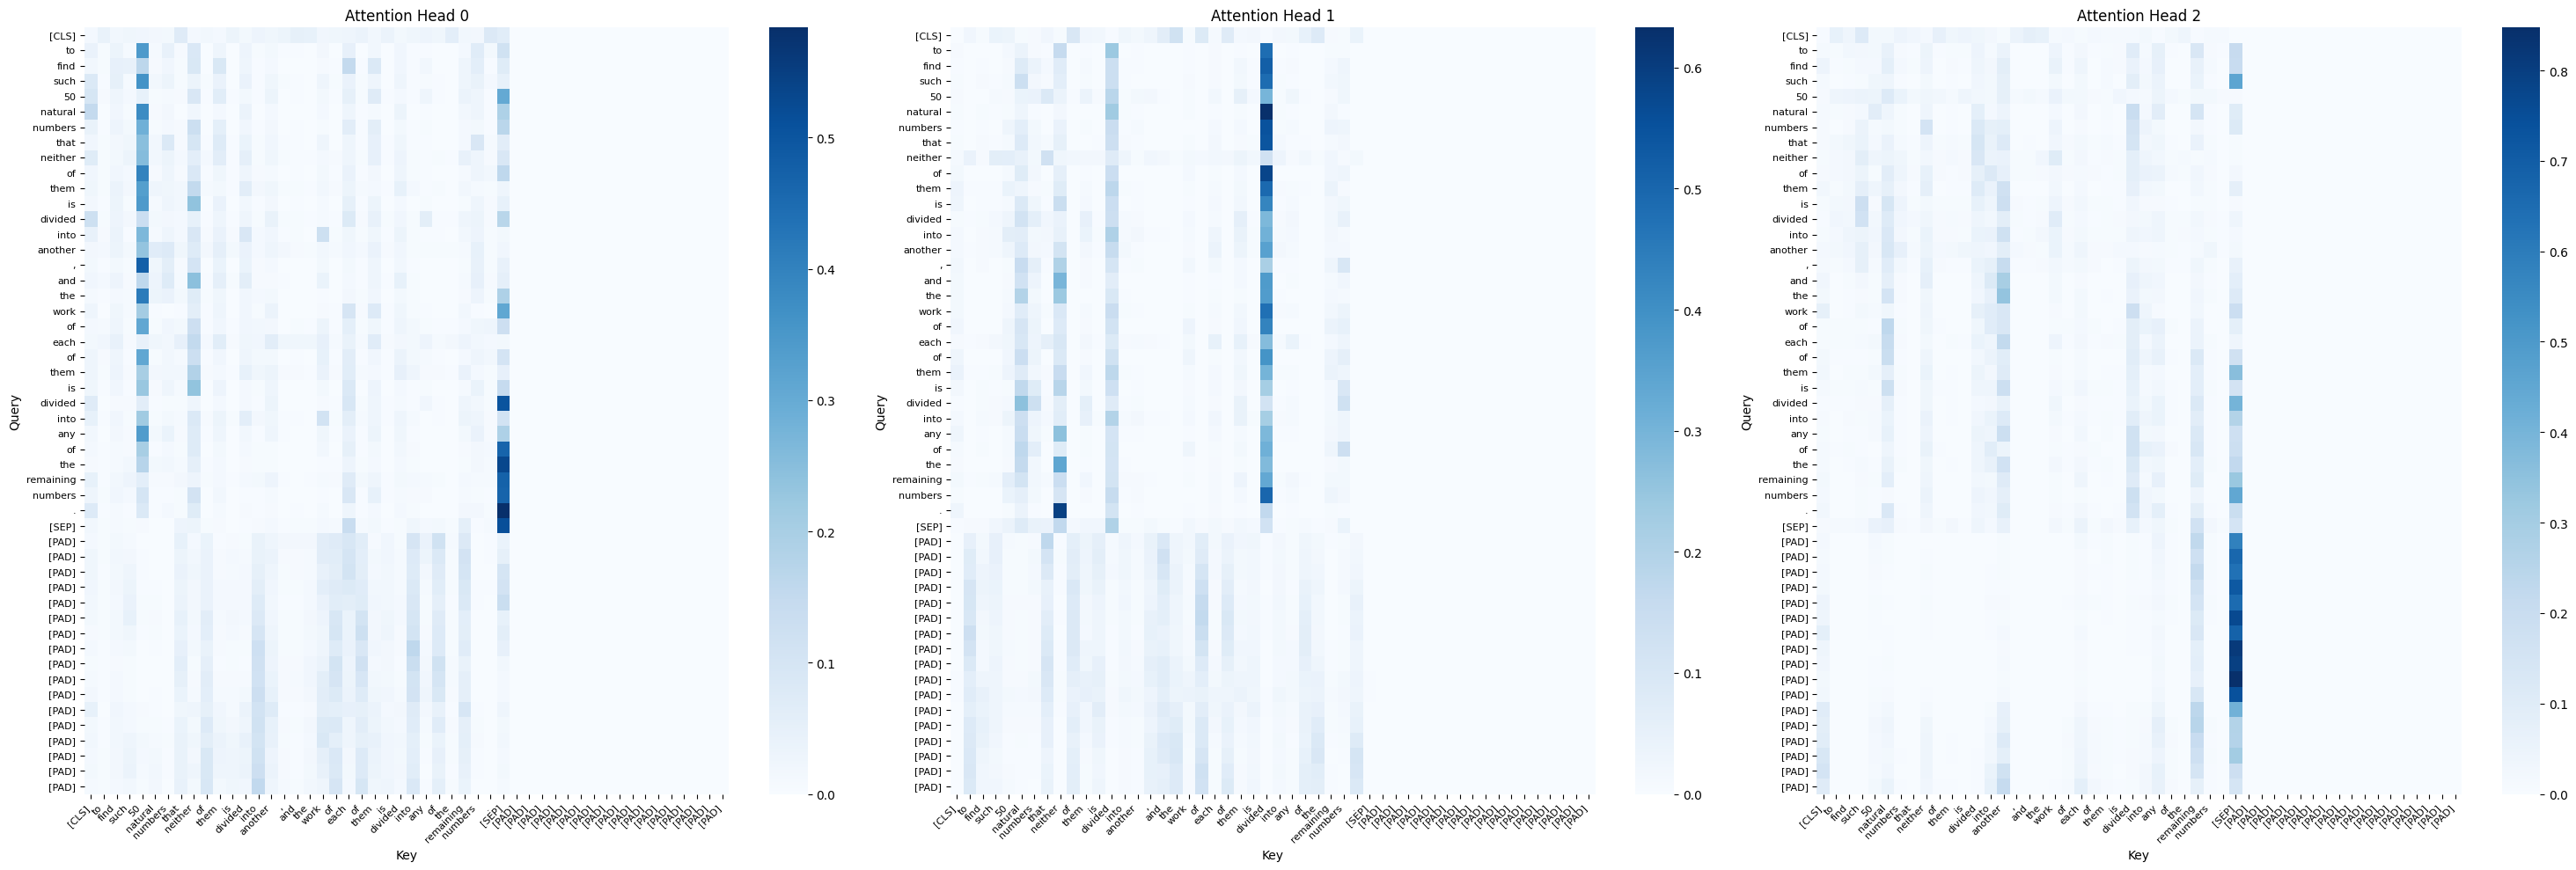

In [22]:
# rubert-tiny2 полностью дообученный
for i, text in enumerate(sample_texts[:2]):
    print(f"\nТекст {i+1}: {text[:100]}...")
    num_heads = rubert_tiny_full_finetuned.backbone.config.num_attention_heads
    head_ids = [0, min(1, num_heads-1), min(2, num_heads-1)][:min(3, num_heads)]
    draw_first_layer_attention_maps(head_ids, text, rubert_tiny_full_finetuned)

# MathBert полностью дообученный
for i, text in enumerate(sample_texts[:2]):
    print(f"\nТекст {i+1}: {text[:100]}...")
    num_heads = mathbert_full_finetuned.backbone.config.num_attention_heads
    head_ids = [0, min(1, num_heads-1), min(2, num_heads-1)][:min(3, num_heads)]
    draw_first_layer_attention_maps(head_ids, text, mathbert_full_finetuned)

Разницы не заметил